### 구글 드라이브 마운트

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# 0. Import

In [ ]:
# 폰트 설치용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
from matplotlib.colors import rgb2hex
from matplotlib.colors import ListedColormap
import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina' #화질 좋게 해주기")
import missingno

from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

# 1. Data Preprocessing

## 1) Train Data set 구축

In [ ]:
df1 = pd.read_excel('/content/gdrive/Shareddrives/2021 진리장학금/data_대회/consumption_US.xlsx')
df2 = pd.read_excel('/content/gdrive/Shareddrives/2021 진리장학금/data_대회/CPI_US.xlsx')
df3 = pd.read_excel('/content/gdrive/Shareddrives/2021 진리장학금/data_대회/GDP_US.xlsx')
df4 = pd.read_excel('/content/gdrive/Shareddrives/2021 진리장학금/data_대회/ffr.xlsx')

In [ ]:
# df1-4 모두 합치기
from functools import reduce
dfs = [df1,df2,df3,df4]
df = reduce(lambda left, right: pd.merge(left, right, on='observation_date', how='outer'), dfs)

In [ ]:
col = ['월','최종소비','내구재','비내구재','서비스','소비자물가지수','GDP','단기이자율_3개월'] # 컬럼명 변경
df.columns = col
df = df.set_index('월')
df = df.reset_index()

# 실수 type으로 변환
for i in col[1:]:
  df[i] = df[i].astype(float)

In [ ]:
# 전년 대비 동분기 로그차분 변화율 변수 생성
df['최종소비_소비변화율'] = (np.log(df['최종소비']) - np.log(df['최종소비']).shift(4))*100
df['내구재_소비변화율'] = (np.log(df['내구재']) - np.log(df['내구재']).shift(4))*100
df['비내구재_소비변화율'] = (np.log(df['비내구재']) - np.log(df['비내구재']).shift(4))*100
df['서비스_소비변화율'] = (np.log(df['서비스']) - np.log(df['서비스']).shift(4))*100

## 2) EDA

### 결측치 확인

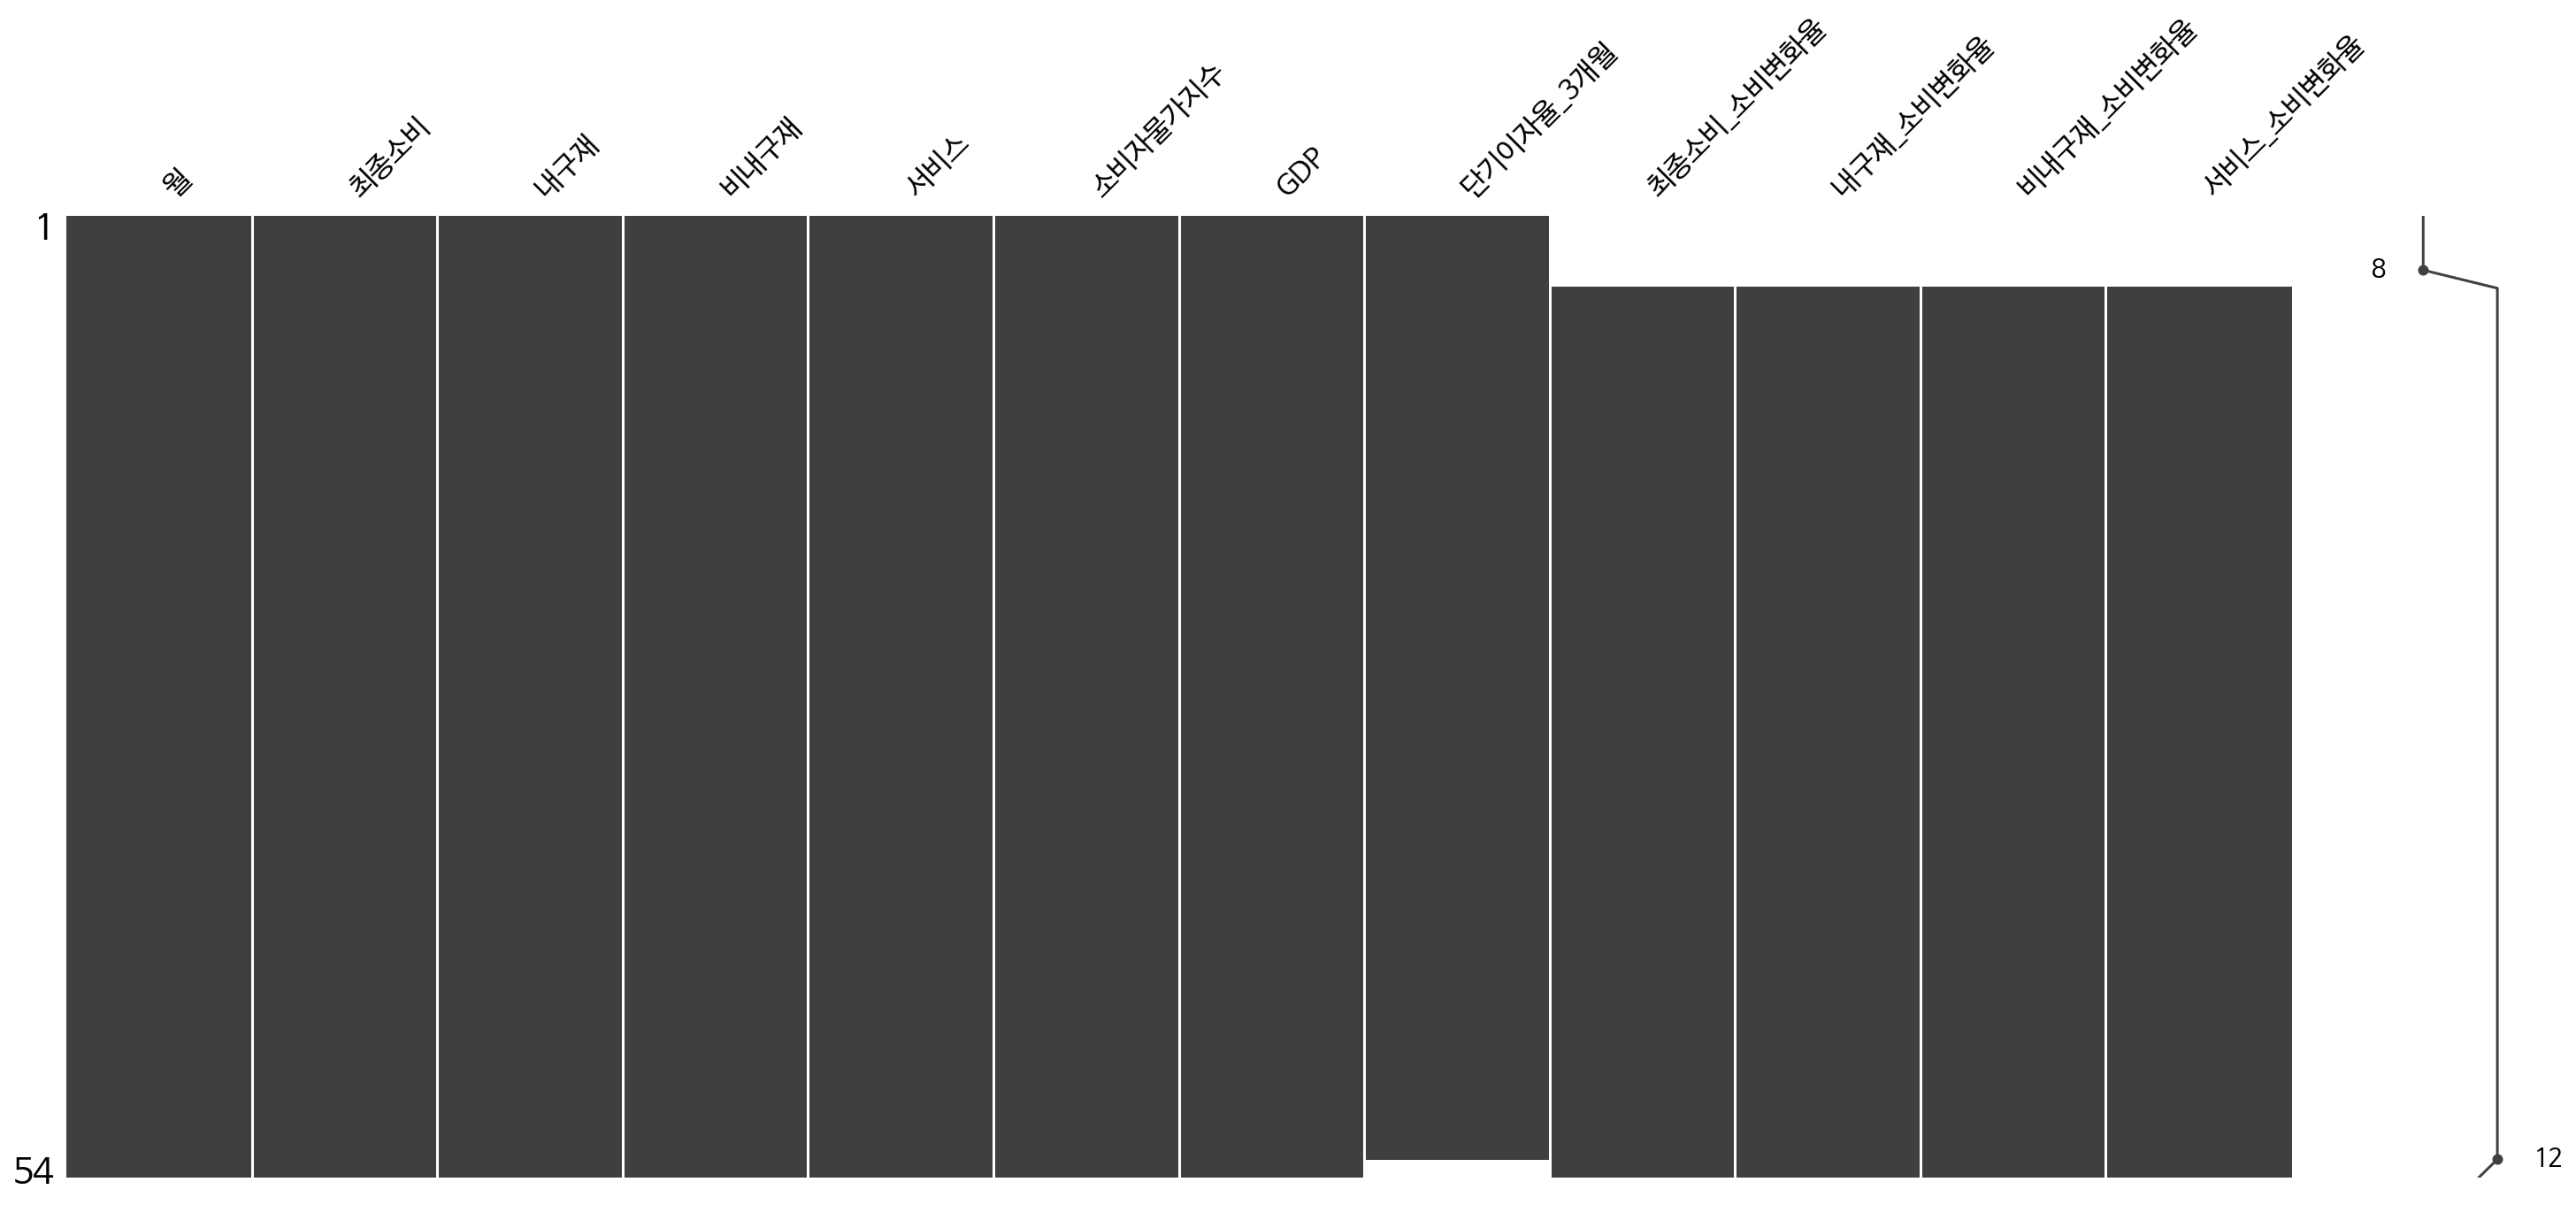

In [ ]:
missingno.matrix(df)

### 평균 제거해주기

In [ ]:
# 변화율 변수만 뽑기
target_col = ['내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율']
df_1 = df[target_col]

# 평균 제거
df_1 = df_1 - df_1.mean()

# 평균 제거한 데이터로 합치기
df_target = df_1
df = pd.concat([df.drop(target_col, axis=1), df_target], axis=1)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


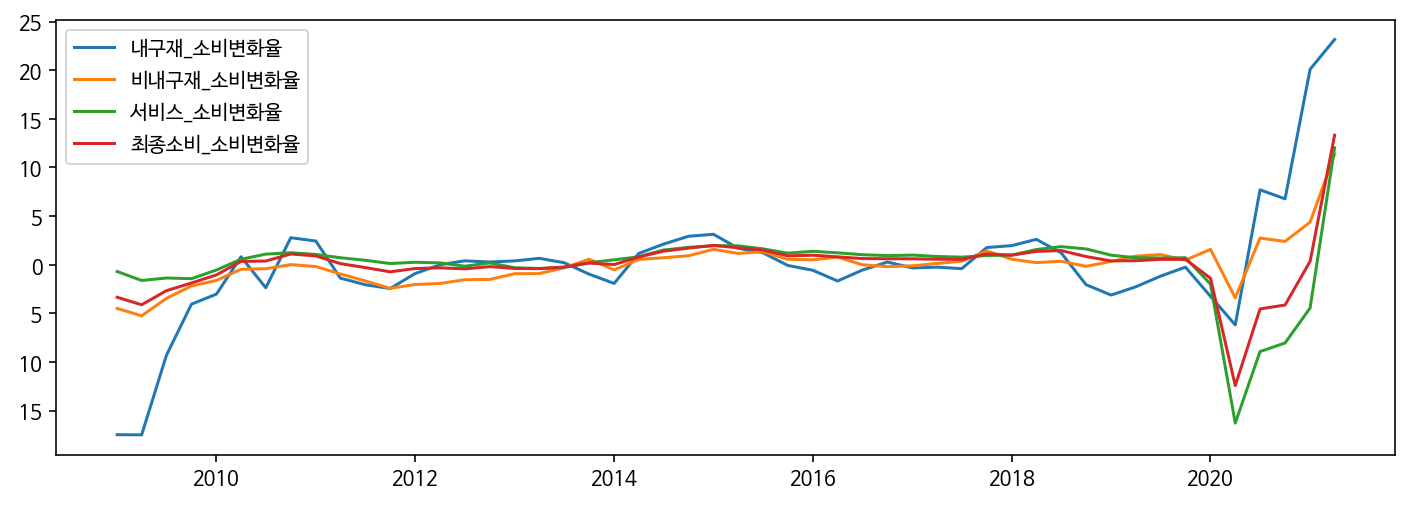

In [ ]:
# 소비변화율 추이
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(df.loc[:, '월'], df.loc[:, '내구재_소비변화율'], label='내구재_소비변화율')
plt.plot(df.loc[:, '월'], df.loc[:, '비내구재_소비변화율'], label='비내구재_소비변화율')
plt.plot(df.loc[:, '월'], df.loc[:, '서비스_소비변화율'], label='서비스_소비변화율')
plt.plot(df.loc[:, '월'], df.loc[:, '최종소비_소비변화율'], label='최종소비_소비변화율')
plt.legend()
plt.show()

# 3. Modeling

## 1) 최종소비

### Train, Test set 분리

In [ ]:
train = df[:47]
test = df[48:].drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)

train_x = train.drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)
train_y = train[['최종소비_소비변화율']]

In [ ]:
# KFold 기법 
cross=KFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in cross.split(train_x, train_y):
    folds.append((train_idx, valid_idx))

### Model 훈련

In [ ]:
models={}
for fold in range(5):
    print(f'===================={fold+1}=======================')
    train_idx, valid_idx=folds[fold]
    X_train=train_x.iloc[train_idx, :]
    y_train=train_y.iloc[train_idx, :]
    X_valid=train_x.iloc[valid_idx, :]
    y_valid=train_y.iloc[valid_idx, :]
    
    model=LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
             early_stopping_rounds=30, verbose=100)
    models[fold]=model
    
    print(f'================================================\n\n')

====================1=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 1.98101


====================2=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================3=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================4=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================5=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 1.18499




### 예측값

In [ ]:
# 예측값 생성
predict = 0
for i in range(5):
    predict += models[i].predict(test)/5

# 날짜 인덱스 생성
date = [np.datetime64('2020-01-01'), np.datetime64('2020-04-01'), np.datetime64('2020-07-01'), 
        np.datetime64('2020-10-01'), np.datetime64('2021-01-01'), np.datetime64('2021-04-01')]

# 데이터프레임으로 합치기
predict_data = pd.DataFrame({'월':date, '최종소비_예측변화율':predict})

# 시각화용 데이터프레임 생성
df2 = df[['월','최종소비_소비변화율']]
df2 = pd.merge(df2, predict_data, on='월', how='outer')
df2['최종소비_예측변화율'][47] = df2['최종소비_소비변화율'][47].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


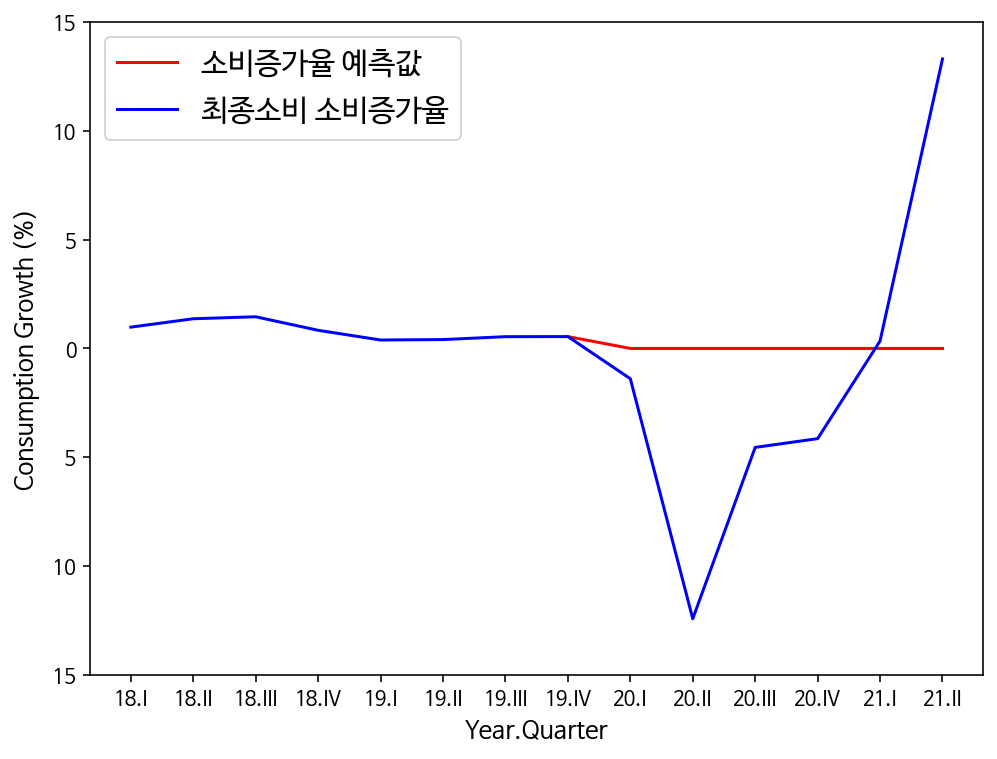

In [ ]:
# 가계소비, 예측소비 추이
plt.rcParams['figure.figsize'] = [8, 6]
df3 = df2[40:]
df3['시기']= ['18.I','18.II','18.III','18.IV','19.I','19.II','19.III','19.IV','20.I','20.II','20.III','20.IV','21.I','21.II']
plt.plot(df3.loc[:, '시기'], df3.loc[:, '최종소비_예측변화율'], label='소비증가율 예측값',color='red')
plt.plot(df3.loc[:, '시기'], df3.loc[:, '최종소비_소비변화율'], label='최종소비 소비증가율',color='blue')
plt.legend(fontsize=15)
plt.xlabel('Year.Quarter',fontsize=12)
plt.ylabel('Consumption Growth (%)',fontsize=12)
plt.ylim([-15,15])
plt.show()

In [ ]:
final2 = df2

## 2) 내구재 소비

### Train, Test set 분리

In [ ]:
train = df[:47]
test = df[48:].drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)

train_x = train.drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)
train_y = train[['내구재_소비변화율']]

In [ ]:
# KFold 기법 
cross=KFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in cross.split(train_x, train_y):
    folds.append((train_idx, valid_idx))

### Model 훈련

In [ ]:
models={}
for fold in range(5):
    print(f'===================={fold+1}=======================')
    train_idx, valid_idx=folds[fold]
    X_train=train_x.iloc[train_idx, :]
    y_train=train_y.iloc[train_idx, :]
    X_valid=train_x.iloc[valid_idx, :]
    y_valid=train_y.iloc[valid_idx, :]
    
    model=LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
             early_stopping_rounds=30, verbose=100)
    models[fold]=model
    
    print(f'================================================\n\n')

====================1=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 33.7024


====================2=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================3=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================4=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================5=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 3.77095




### 예측값

In [ ]:
# 예측값 생성
predict = 0
for i in range(5):
    predict += models[i].predict(test)/5

# 날짜 인덱스 생성
date = [np.datetime64('2020-01-01'), np.datetime64('2020-04-01'), np.datetime64('2020-07-01'), 
        np.datetime64('2020-10-01'), np.datetime64('2021-01-01'), np.datetime64('2021-04-01')]

# 데이터프레임으로 합치기
predict_data = pd.DataFrame({'월':date, '내구재_예측변화율':predict})

# 시각화용 데이터프레임 생성
df2 = df[['월','내구재_소비변화율']]
df2 = pd.merge(df2, predict_data, on='월', how='outer')
df2['내구재_예측변화율'][47] = df2['내구재_소비변화율'][47].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


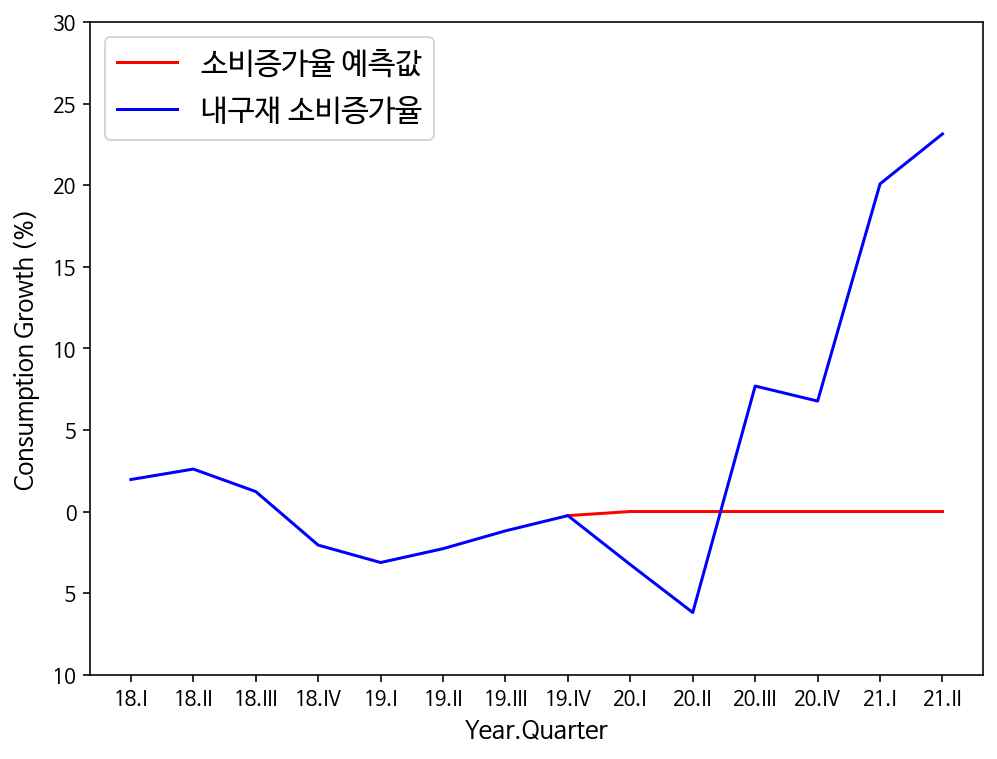

In [ ]:
# 가계소비, 예측소비 추이
plt.rcParams['figure.figsize'] = [8, 6]
df3 = df2[40:]
df3['시기']= ['18.I','18.II','18.III','18.IV','19.I','19.II','19.III','19.IV','20.I','20.II','20.III','20.IV','21.I','21.II']
plt.plot(df3.loc[:, '시기'], df3.loc[:, '내구재_예측변화율'], label='소비증가율 예측값',color='red')
plt.plot(df3.loc[:, '시기'], df3.loc[:, '내구재_소비변화율'], label='내구재 소비증가율',color='blue')
plt.legend(fontsize=15)
plt.xlabel('Year.Quarter',fontsize=12)
plt.ylabel('Consumption Growth (%)',fontsize=12)
plt.ylim([-10,30])
plt.show()

In [ ]:
us_data = pd.merge(final2, df2, on='월')

## 3) 비내구재 소비

### Train, Test set 분리

In [ ]:
train = df[:47]
test = df[48:].drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)

train_x = train.drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)
train_y = train[['비내구재_소비변화율']]

In [ ]:
# KFold 기법 
cross=KFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in cross.split(train_x, train_y):
    folds.append((train_idx, valid_idx))

### Model 훈련

In [ ]:
models={}
for fold in range(5):
    print(f'===================={fold+1}=======================')
    train_idx, valid_idx=folds[fold]
    X_train=train_x.iloc[train_idx, :]
    y_train=train_y.iloc[train_idx, :]
    X_valid=train_x.iloc[valid_idx, :]
    y_valid=train_y.iloc[valid_idx, :]
    
    model=LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
             early_stopping_rounds=30, verbose=100)
    models[fold]=model
    
    print(f'================================================\n\n')

====================1=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 2.65335


====================2=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================3=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================4=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================5=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 1.63783




### 예측값

In [ ]:
# 예측값 생성
predict = 0
for i in range(5):
    predict += models[i].predict(test)/5

# 날짜 인덱스 생성
date = [np.datetime64('2020-01-01'), np.datetime64('2020-04-01'), np.datetime64('2020-07-01'), 
        np.datetime64('2020-10-01'), np.datetime64('2021-01-01'), np.datetime64('2021-04-01')]

# 데이터프레임으로 합치기
predict_data = pd.DataFrame({'월':date, '비내구재_예측변화율':predict})

# 시각화용 데이터프레임 생성
df2 = df[['월','비내구재_소비변화율']]
df2 = pd.merge(df2, predict_data, on='월', how='outer')
df2['비내구재_예측변화율'][47] = df2['비내구재_소비변화율'][47].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


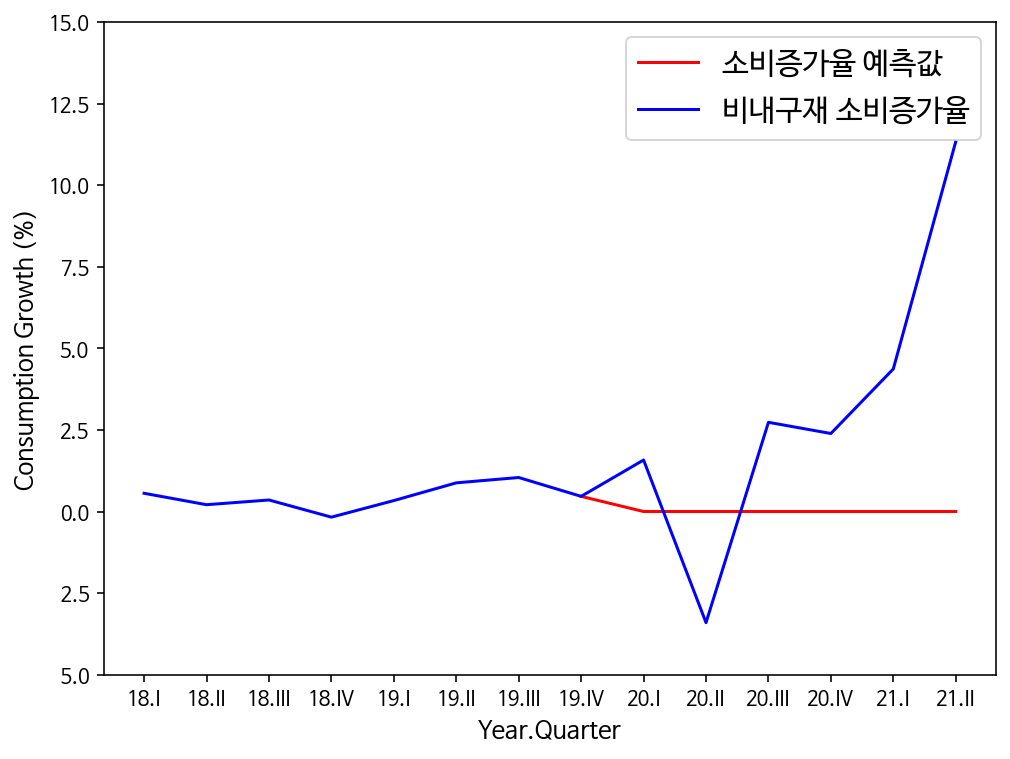

In [ ]:
# 가계소비, 예측소비 추이
plt.rcParams['figure.figsize'] = [8, 6]
df3 = df2[40:]
df3['시기']= ['18.I','18.II','18.III','18.IV','19.I','19.II','19.III','19.IV','20.I','20.II','20.III','20.IV','21.I','21.II']
plt.plot(df3.loc[:, '시기'], df3.loc[:, '비내구재_예측변화율'], label='소비증가율 예측값',color='red')
plt.plot(df3.loc[:, '시기'], df3.loc[:, '비내구재_소비변화율'], label='비내구재 소비증가율',color='blue')
plt.legend(fontsize=15)
plt.xlabel('Year.Quarter',fontsize=12)
plt.ylabel('Consumption Growth (%)',fontsize=12)
plt.ylim([-5,15])
plt.show()

In [ ]:
us_data = pd.merge(us_data, df2, on='월')

## 4) 서비스 소비

### Train, Test set 분리

In [ ]:
train = df[:47]
test = df[48:].drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)

train_x = train.drop(['월','내구재_소비변화율','비내구재_소비변화율','서비스_소비변화율','최종소비_소비변화율'], axis=1)
train_y = train[['서비스_소비변화율']]

In [ ]:
# KFold 기법 
cross=KFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in cross.split(train_x, train_y):
    folds.append((train_idx, valid_idx))

### Model 훈련

In [ ]:
models={}
for fold in range(5):
    print(f'===================={fold+1}=======================')
    train_idx, valid_idx=folds[fold]
    X_train=train_x.iloc[train_idx, :]
    y_train=train_y.iloc[train_idx, :]
    X_valid=train_x.iloc[valid_idx, :]
    y_valid=train_y.iloc[valid_idx, :]
    
    model=LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
             early_stopping_rounds=30, verbose=100)
    models[fold]=model
    
    print(f'================================================\n\n')

====================1=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 1.24526


====================2=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================3=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================4=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: nan


====================5=======================
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's l2: nan	valid_1's l2: 1.20008




### 예측값

In [ ]:
# 예측값 생성
predict = 0
for i in range(5):
    predict += models[i].predict(test)/5

# 날짜 인덱스 생성
date = [np.datetime64('2020-01-01'), np.datetime64('2020-04-01'), np.datetime64('2020-07-01'), 
        np.datetime64('2020-10-01'), np.datetime64('2021-01-01'), np.datetime64('2021-04-01')]

# 데이터프레임으로 합치기
predict_data = pd.DataFrame({'월':date, '서비스_예측변화율':predict})

# 시각화용 데이터프레임 생성
df2 = df[['월','서비스_소비변화율']]
df2 = pd.merge(df2, predict_data, on='월', how='outer')
df2['서비스_예측변화율'][47] = df2['서비스_소비변화율'][47].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


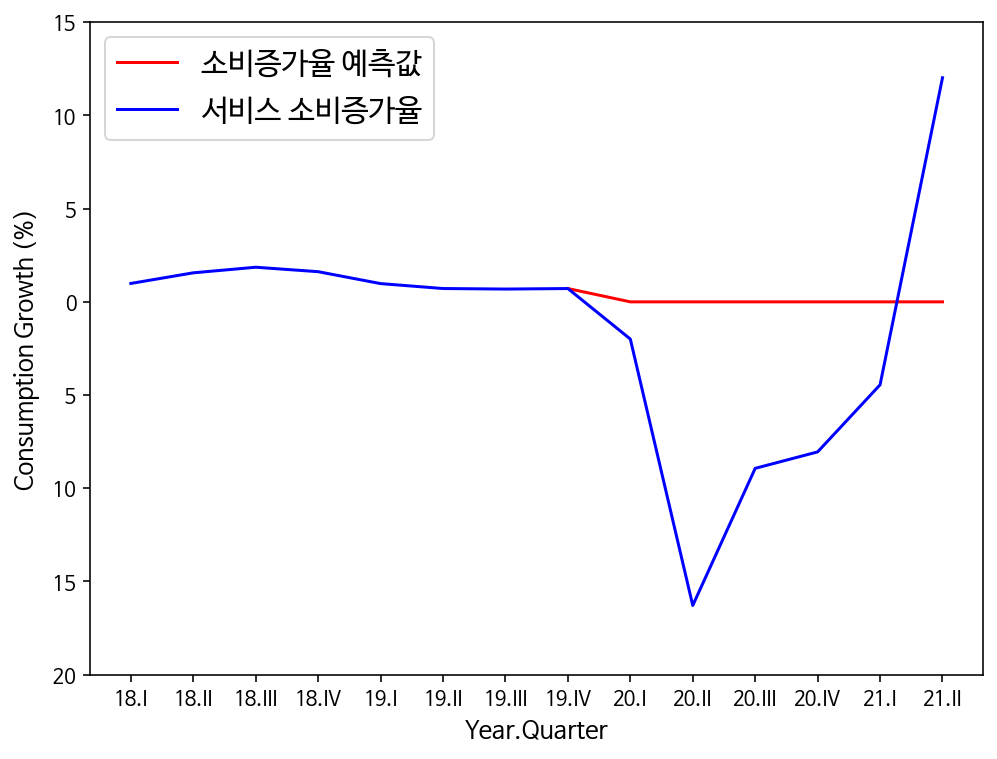

In [ ]:
# 가계소비, 예측소비 추이
plt.rcParams['figure.figsize'] = [8, 6]
df3 = df2[40:]
df3['시기']= ['18.I','18.II','18.III','18.IV','19.I','19.II','19.III','19.IV','20.I','20.II','20.III','20.IV','21.I','21.II']
plt.plot(df3.loc[:, '시기'], df3.loc[:, '서비스_예측변화율'], label='소비증가율 예측값',color='red')
plt.plot(df3.loc[:, '시기'], df3.loc[:, '서비스_소비변화율'], label='서비스 소비증가율',color='blue')
plt.legend(fontsize=15)
plt.xlabel('Year.Quarter',fontsize=12)
plt.ylabel('Consumption Growth (%)',fontsize=12)
plt.ylim([-20,15])
plt.show()

In [ ]:
us_data = pd.merge(us_data, df2, on='월')

In [ ]:
us_data.to_csv('us_data.csv')